---
# Final Analyses

After `dn_compare.ipynb`, this notebook includes some of the final figures

In [1]:
from linescanning import (
    utils,
    fitting,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import holeresponse as hr
import nibabel as nb
import seaborn as sns
import pingouin as pg
from scipy import stats
opj = os.path.join
opd = os.path.dirname

In [2]:
from lazyplot import *

In [4]:
plotting

<module 'lazyplot.plotting' from '/data1/projects/MicroFunc/Jurjen/programs/packages/LazyPlot/lazyplot/plotting.py'>

### GLMs

In [5]:
# import subject dictionary containing useful information
include_subjs = ["001","002","005","006","008","010","011","013","014","015","022"]
subj_obj = hr.utils.SubjectsDict(proj_dir="/data1/projects/MicroFunc/Jurjen/projects/VE-NORDIC")
subj_obj.proj_dir

glms = pd.read_csv(opj(subj_obj.repo_dir,"data","center_large_glm_projections.csv"))
glms

,Unnamed: 0,beta,tstat,r2,subject,model,model_ix,method,preproc,event_type
0,0,0.981313,2.956407,0.326860,8,linear,0,raw,uncorr,center
1,0,-0.398325,-1.404422,0.396841,8,camel,1,raw,uncorr,center
2,0,-1.791440,-2.029122,0.606952,8,camel_deriv,2,raw,uncorr,center
3,1,0.678075,3.011143,0.334983,10,linear,0,raw,uncorr,center
4,1,0.469938,2.792047,0.544059,10,camel,1,raw,uncorr,center
...,...,...,...,...,...,...,...,...,...,...
454,9,-0.549536,-2.120864,0.427166,15,camel,1,norm,corr,large\nannulus
455,9,-1.595243,-2.136857,0.680206,15,camel_deriv,2,norm,corr,large\nannulus
456,10,1.093579,4.921469,0.573670,22,linear,0,norm,corr,large\nannulus
457,10,0.452464,2.694858,0.701281,22,camel,1,norm,corr,large\nannulus


In [6]:
all_profiles = pd.read_csv(opj(subj_obj.repo_dir,"data","camel_profiles.csv")).set_index(["preproc","method","event_type","subject"])
all_betas = pd.read_csv(opj(subj_obj.repo_dir,"data","camel_betas.csv")).set_index(["event_type","method","preproc","model","model_ix"])

#### Center vs large

In [7]:
n_steps = all_profiles.shape[-1]
xx = np.arange(0,n_steps)
y1 = xx.copy()[::-1]
y1 = y1/y1.max()

y2 = np.linspace(-n_steps//2,n_steps//2,num=n_steps)
y2 = (y2**2)
y2 = y2/y2.max()

y = np.linspace(-10,10,num=20)
# print(y2.shape)
# y2 = (y2**2)
fc = 5
y_1 = stats.norm.pdf(y,-fc)
y_1 = y_1/y_1.max()
y_1d = np.gradient(y_1)

y_2 = stats.norm.pdf(y,fc)
y_2 = y_2/y_2.max()
y_2d = np.gradient(y_2)

y3 = y_1+y_2

reg_dict = {
    "linear": y1[...,np.newaxis],
    "camel": np.concatenate(
        [
            y1[...,np.newaxis],     # linear term
            y3[...,np.newaxis],    # fixed bumps
        ],
        axis=1
    )
}

# combine linear & camel
reg_dict["camel_deriv"] = np.concatenate(
    [
        y1[...,np.newaxis],     # linear term
        y_1[...,np.newaxis],    # first bump
        y_2[...,np.newaxis],    # second bump
        y_1d[...,np.newaxis],   # first bump deriv
        y_2d[...,np.newaxis]    # second bump deriv
    ],
    axis=1
)


              W      pval  normal
beta  0.939402  0.192378    True

        Source  ddof1  ddof2          F     p-unc      np2
0  event_type      1     20  10.310854  0.004384  0.34017


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen,distances
0,event_type,center,large\nannulus,True,True,-4.005559,10.0,two-sided,0.002496,18.86,-1.369197,1


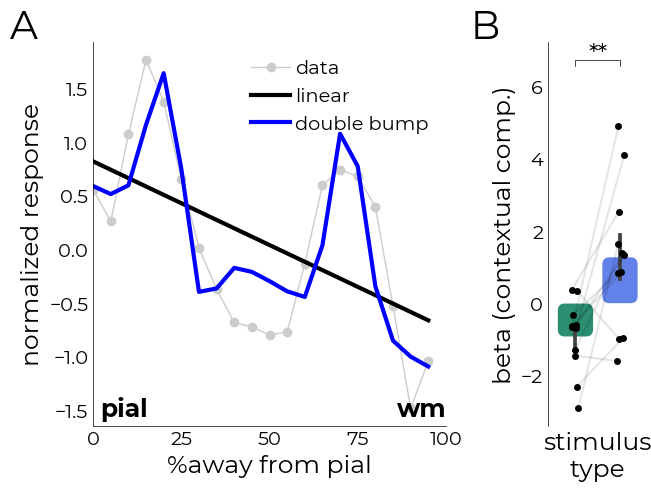

In [10]:
%matplotlib inline
n_elem = all_betas.shape[1]

colors = sns.color_palette("viridis", n_elem)
ev = "large\nannulus"
expr = [
    f"event_type = {ev}",
    "method = norm"
]

be = utils.multiselect_from_df(
    all_betas,
    expression=expr
)

data = utils.multiselect_from_df(all_profiles, expression=expr+["preproc = corr","method = norm"]).values.T

icpt = np.ones((data.shape[0],1))
fig,axs = plt.subplots(
    ncols=2, 
    width_ratios=[0.8,0.2], 
    constrained_layout=True
)

ix = 0
sub_name = f"sub-{str(ix+1).zfill(2)}"
lbl = {
    "linear": "linear",
    "camel": "double",
    "camel_deriv": "double bump"
}

incl_models = [
    "linear",
    "camel_deriv"
]
data_list = [data[:,ix]]
# cm = sns.color_palette("Reds", len(incl_models))
cm = ["k","b"]

for key,val in reg_dict.items():
    
    if key in incl_models:
        be1 = utils.select_from_df(be, expression=f"model = {key}").values
        dm = np.concatenate([icpt,val], axis=-1)

        y_hat = np.dot(dm,be1)
        data_list.append(y_hat[:,ix])

ddict = hr.viz.make_wm_pial_ticks(data_list[0])
def_dict = {
    "color": ["#cccccc"]+cm,
    "axs": axs[0],
    "line_width": [1]+[3 for i in range(len(incl_models))],
    "markers": ["o"]+[None for i in range(len(incl_models))],
    "labels": ["data"]+[lbl[i] for i in incl_models],
    "x_ticks": ddict["ticks"],
    "x_ticklabels": ddict["labels"],
    "x_label": "%away from pial",
    "y_label": "normalized response",
}

pl = plotting.LazyLine(
    data_list,
    **def_dict
)

hr.viz.annotate_cortical_ribbon(
    axs[0],
    pial_pos=(0.02,0.025),
    wm_pos=(0.86,0.025),
    fontsize=pl.font_size,
    fontweight="bold"
)

stat = "beta"
if stat == "tstat":
    lbl = "t-stat"
else:
    lbl = stat
    
br = plotting.LazyBar(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "event_type != medium\nannulus",
            "model = camel_deriv"
        ]
    ),
    x="event_type",
    y=stat,
    x_label="stimulus\ntype",
    axs=axs[1],
    add_points=True,
    points_color="k",
    y_label=f"{lbl} (contextual comp.)",
    sns_offset=4,
    bar_legend=True,
    sns_rot=-25,
    # title={
    #     "title": f"{key} | {vi}",
    #     "fontweight": "bold"
    # },
    bbox_to_anchor=(0.8,0.9),
    fancy=True,
    palette=subj_obj.ev_colors[::2],
    connect=True
)

normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]
aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "subject",
        "padjust": "hilm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

plotting.fig_annot(
    fig,
    axs=list(fig.axes),
    x0_corr=-0.85,
    x_corr=[-0.85]
)


print("\n", normality)
print("\n", aov.ano)
aov.posthoc


In [13]:
plotting.__file__

'/data1/projects/MicroFunc/Jurjen/programs/packages/LazyPlot/lazyplot/plotting.py'

#### Add medium to the mix


              W      pval  normal
beta  0.948999  0.124379    True

        Source  ddof1  ddof2         F     p-unc       np2
0  event_type      2     30  7.107614  0.002973  0.321501


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen,distances
0,event_type,center,large\nannulus,True,True,-4.005559,10.0,two-sided,0.002496,0.007488,holm,18.86,-1.369197,2
1,event_type,center,medium\nannulus,True,True,-3.146138,10.0,two-sided,0.010401,0.020802,holm,5.864,-1.505014,1
2,event_type,large\nannulus,medium\nannulus,True,True,1.330295,10.0,two-sided,0.212961,0.212961,holm,0.603,0.571084,1


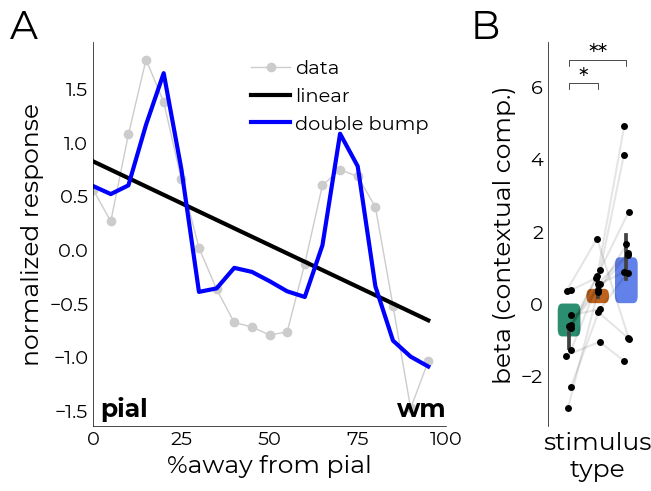

In [12]:
%matplotlib inline
n_elem = all_betas.shape[1]

colors = sns.color_palette("viridis", n_elem)
ev = "large\nannulus"
expr = [
    f"event_type = {ev}",
    "method = norm"
]

be = utils.multiselect_from_df(
    all_betas,
    expression=expr
)

data = utils.multiselect_from_df(all_profiles, expression=expr+["preproc = corr","method = norm"]).values.T

icpt = np.ones((data.shape[0],1))
fig,axs = plt.subplots(
    ncols=2, 
    width_ratios=[0.8,0.2], 
    constrained_layout=True
)

ix = 0
sub_name = f"sub-{str(ix+1).zfill(2)}"
lbl = {
    "linear": "linear",
    "camel": "double",
    "camel_deriv": "double bump"
}

incl_models = [
    "linear",
    "camel_deriv"
]
data_list = [data[:,ix]]
# cm = sns.color_palette("Reds", len(incl_models))
cm = ["k","b"]

for key,val in reg_dict.items():
    
    if key in incl_models:
        be1 = utils.select_from_df(be, expression=f"model = {key}").values
        dm = np.concatenate([icpt,val], axis=-1)

        y_hat = np.dot(dm,be1)
        data_list.append(y_hat[:,ix])

ddict = hr.viz.make_wm_pial_ticks(data_list[0])
def_dict = {
    "color": ["#cccccc"]+cm,
    "axs": axs[0],
    "line_width": [1]+[3 for i in range(len(incl_models))],
    "markers": ["o"]+[None for i in range(len(incl_models))],
    "labels": ["data"]+[lbl[i] for i in incl_models],
    "x_ticks": ddict["ticks"],
    "x_ticklabels": ddict["labels"],
    "x_label": "%away from pial",
    "y_label": "normalized response",
}

pl = plotting.LazyLine(
    data_list,
    **def_dict
)

hr.viz.annotate_cortical_ribbon(
    axs[0],
    pial_pos=(0.02,0.025),
    wm_pos=(0.86,0.025),
    fontsize=pl.font_size,
    fontweight="bold"
)

stat = "beta"
if stat == "tstat":
    lbl = "t-stat"
else:
    lbl = stat
    
br = plotting.LazyBar(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    ),
    x="event_type",
    y=stat,
    x_label="stimulus\ntype",
    axs=axs[1],
    add_points=True,
    points_color="k",
    y_label=f"{lbl} (contextual comp.)",
    sns_offset=4,
    bar_legend=True,
    sns_rot=-25,
    # title={
    #     "title": f"{key} | {vi}",
    #     "fontweight": "bold"
    # },
    bbox_to_anchor=(0.8,0.9),
    fancy=True,
    palette=subj_obj.ev_colors,
    connect=True
)


normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "subject",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

plotting.fig_annot(
    fig,
    axs=list(fig.axes),
    x0_corr=-0.85,
    x_corr=[-0.85]
)

print("\n", normality)
print("\n", aov.ano)
aov.posthoc

In [13]:
pg.homoscedasticity(br.data, dv=br.y, group="event_type")

,W,pval,equal_var
levene,3.531792,0.041938,False


In [14]:
from lazyplot import fitting